In [ ]:
from slugify import slugify
import numpy as np
import pandas as pd
import scipy.stats


import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
from pymc import Gamma, Poisson, Exponential, Model

import json

import dcs
import priors
import pgamma

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
ref_prior = (1, 100)

# location data: characteristices of the sensors
bi = pd.read_csv("dc_locations.csv")
bi["sensor"] = bi["sensor"].map(lambda x: slugify(x))

# the guesses from the students
guessed = pd.read_csv('guesses.csv')

report_name="Lac Léman"
# the column name in the survey data and
# location data where the feature_name will
# be found
feature="feature"
# the region of interest
feature_name="lac-leman"
# retrieve the current data and the most common codes for the region of interest
report_leman, codes = pgamma.get_most_common_and_aggregated_feature_report(report_name=report_name, pg=feature, pgn=feature_name)
# get the report ot the most common codes
dr = report_leman.make_report_code_summary()
# the columns need to be renamed for this usage
de = dr[1:]
di = pd.DataFrame(de)
di.columns = dr[0]
# limit the report to only the codes of interest
di = di[di.Code.isin(codes)]
xi = di[['Code', 'Description', 'N pieces', 'pcs/m','Fail rate']]
# export to .json
x = xi.to_dict(orient="records")
with open("most_common_json.json", "w") as afile:
    json.dump(x, afile)

regional_surveys = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]

# the uptodate data for lac leman
eix = pd.read_csv("ei_uptotdate.csv")
eix["date"] = pd.to_datetime(eix["date"])

# the data prior to the sample date
ei = eix[eix["date"] < "2022-10-01"]

# mask for the most common codes
code_mask = (ei.code.isin(codes))

# regressors
variables = ["lake", "grand-lac", 'Saint-Sulpice (VD)']

# the columns of interest
columns = ["pcs_m","quantity", "group", "code", "loc_date", "sensor", *variables]

d = ei[code_mask].copy()

regional_mask = d.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (d.city == 'Saint-Sulpice (VD)')
# the easiest way to get summary data from IQAASL
# is to use the module for that purpose


log started


## Prior information

### Prior data

The prior data is all survey records on Lake Geneva from 2015 to October 1, 2022.

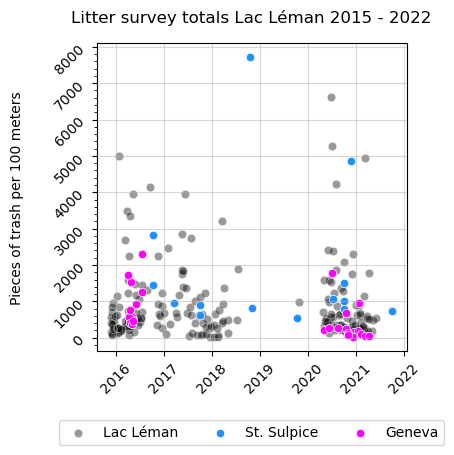

In [ ]:
# the survey totals for the lake and Saint Sulpice
# the sum in pcs/100m of each sample since 2015
sp_prior = ei[(ei.city ==  'Saint-Sulpice (VD)')].copy()
g_prior = ei[(ei.city ==  'Genève')].copy()
cdt = sp_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
gdt = g_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
daily_totals = ei.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
fig, ax = plt.subplots(figsize=(4, 4))

daily_totals["date"] = pd.to_datetime(daily_totals["date"])
cdt["date"] =  pd.to_datetime(cdt["date"])
gdt["date"] =  pd.to_datetime(gdt["date"])

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", color="black", alpha=0.4, label="Lac Léman", ax=ax)
sns.scatterplot(data=cdt, x="date", y="pcs_m", color="dodgerblue", label="St. Sulpice", ax=ax)
sns.scatterplot(data=gdt, x="date", y="pcs_m", color="magenta", label="Geneva", ax=ax)
ax.set_ylabel("Pieces of trash per 100 meters", labelpad=20)
ax.set_xlabel(" ")
ax.set_title("Litter survey totals Lac Léman 2015 - 2022", fontsize=12, pad=15)
ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.legend(bbox_to_anchor=(0.5,-.2), loc="upper center", ncol=3)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='major', axis='both', alpha=0.5)
plt.savefig("survey_totals.png", dpi=300)
plt.show()

### Summary of prior knowledge

We assume that the beach litter survey results are **vectors** that describe the interaction/exchange of trash (all sizes > 0mm) between the survey location and the body of water it borders. *Body of water* refers to areas of reduced current flow in a river basin. For example lake Geneva to the Rhône or Bielersee to the Aare. Therefore, the magnitude of the interaction/exchange is quantified by the rate component of the vector that describes the interaction.  

1. The survey results represent the minimum possible value for an object. It is certain that not all objects that were present at a location were indetified and counted. Furtthermore, objects that are found can be misidentified or the wrong code applied to the record upon data entry.

2. There is a relationship to the number of objects suspended in the body of water and the number of objects that are counted and identitfied in the strand-line at a survey. The number of objects in suspension is unknown.

3. Objects in suspension are trasnported according to the direction of the river basin, surface currents, wind currents and meteorological events. The magnitude of the exchange of objects between the shoreline and the body of water is also influenced by local topography. The magnitued of this exchange is unknown for the lake in general nor for any location in particular.

4. Each location or beach produces/emitts particles that are exchanged with the lake. Those particles get transported according to 3. 

5. Storm water drains, streams, rivers and canals ( hydrologic inputs ) are sources of particles in suspension. The number and size of hydrologic inputs is a factor in the number of particles in suspension for a  body of water.

The magnitude of the *trash* vector on the beach is the result of many interactions. One possible method to forecasting results could include quantifying each interaction term. This would be helpfull information but is not strictly required. From a resource perspective this would require that three additional sources of information (for each quantified interaction) be maintained and accessible for each location so that forecasting could be accomplished. None of which currently exist at a required precision level for any specific location. The question is about the magnitude of the *trash* vector and not any other attribute, for this there is direct evidence. The shortcomings or bias of this evidence is summarized in 1.

The Negative Binomial distribution has been suggested by WRU and the JRC when calculating trend lines using a Generalized Linear Model (GLM) or identifying extreme values from a dataset ( JRC ). The GLM method proposed by WRU use the survey totals and group totals to determine trend lines, with the recomendation to use objects that are indentified frequently. The example in the report is Single Use Plastics (SUPS). This method does not exclude any survey results and is constrained geographically. 

#### Models and priors

**Prior data:** The method proposed by WRU is attractive because of the properties of the NB and its use in evaluating count data in many other fields. We define objects that are *identified frequently* as any object that was found in at least 50% of the surveys or any object with a cumulative total that places them in the top ten most abundant.

**Model:** Given conditions 2-5 we assume that the survey results for the most common objects are NB distributed with parameters $\alpha$ and $\lambda$. $A$ is Exponentialy distributed with parameter $i$ and $\Lambda$ is the result of a linear approximation of $B_{i}, X_{i}$. $B$ is the intercept and $B_{i}$ is the magnitude of the interaction term for the undefined values previously cited. Both are assumed normally disributed for any individual location or region.

$$
\begin{aligned} 
Y  &\sim NB(\lambda, \alpha) \\
\alpha &\sim Exponential(i) \\
\lambda &= B + B_0 X_0 + B_1 X_1 + B_2 X_2 \\
B &\sim  N(\mu, \sigma) \\
B_{i} &\sim N(\mu, \sigma) \\
\end{aligned}
$$

The variance of the survey results increase with the required geographical precision of the assessment. This relationship is in part due to the decreasing number of samples per region or sub region, ie. there are 250  surveys for the lake and only 15 for Saint Sulpice. The average pcs/100m at Saint Sulpice is double that of the lake, while the average of the grand-lac is very close to the lake.

The intended purpose of the model is to allow end users to consult current and predicted values for any number of planning purposes. This includes planning holiday weekends or designing a process that is supposed to reduce trash in the water for a region or body of water. Our conditions of success are focussed on practicallity and implementation. The testing of the model and the results from those tests should be easy to consult and understand. The definitive test should always be a direct comparison between what was found and the forecast. The initial test period should be as long as the baseline collection period. In this case one year.

**Conditions of success:**

1. On average have a better prediction rate than a random guess
2. The forecast describes a compromise between the city and the subregion
3. Predicted values are reasonable compared to historical results
4. The forecast is sensitive to the addition of new information

### Summary of results by region and subregion

The mean pcs/100m of the most common objects indentified for the period 2020-2021.

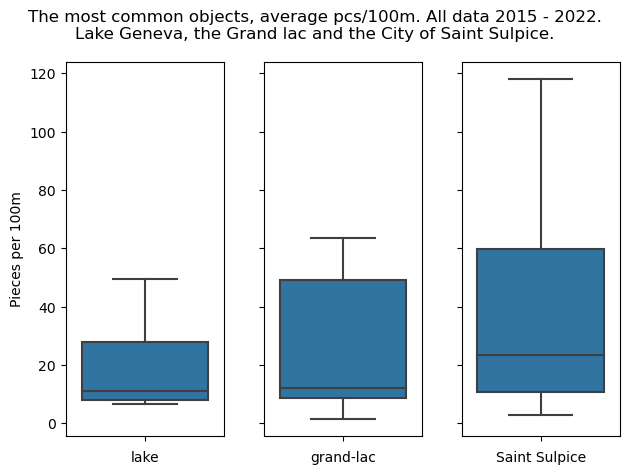

In [ ]:
mean_pcode = ei.groupby("code").pcs_m.mean()
def add_group(x, anarray, agroup, akey):
    
    if x in anarray:
        data = agroup
    else:
        data = akey
    return data
    
    
d = ei[ei.code.isin(codes)].copy()
d["mean_c"] = d["code"].map(lambda x: mean_pcode.loc[x])
d["mean_diff"] = d["pcs_m"] - d["mean_c"]
d["mean_diff_sqrd"] = d["mean_diff"]**2
d["root_mean_diff"] = d["mean_diff_sqrd"]**1/2
d["group"] = "lake"
d["group"] = d["city"].map(lambda x: add_group(x, regional_surveys, "grand-lac", "lake"))
# d = d.sort_values(by="pcs_m")

fig, ax = plt.subplots(1,3, sharey=True)


xlabels = ["lake", "grand-lac", "Saint Sulpice"]

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]



done = d.groupby("code", as_index=False)["pcs_m"].mean()
dtwo = d[d.group == "grand-lac"].groupby("code", as_index=False)["pcs_m"].mean()
dthree = d[d.city == 'Saint-Sulpice (VD)'].groupby("code", as_index=False)["pcs_m"].mean()

for i, anax in enumerate([ax1, ax2, ax3]):
    anax.set_xlabel(xlabels[i])



sns.boxplot(data=done, y="pcs_m",  showfliers=False, ax=ax1)
sns.boxplot(data=dtwo, y="pcs_m",  showfliers=False, ax=ax2)
sns.boxplot(data=dthree, y="pcs_m",  showfliers=False, ax=ax3)


for anax in [ax2, ax3]:
    anax.set_ylabel(" ")


title_one = "The most common objects, average pcs/100m. All data 2015 - 2022."
title_two = "Lake Geneva, the Grand lac and the City of Saint Sulpice."

ax1.set_ylabel("Pieces per 100m")
plt.suptitle(f"{title_one}\n{title_two}")
plt.tight_layout()
plt.savefig("most_common_objects_regional_av.jpeg", dpi=300)
plt.show()

In [ ]:
fsummaries = f"""

Summary lake:
{done.pcs_m.describe()}

Summary grand-lac:
{dtwo.pcs_m.describe()}

Summary Saint Sulpice:
{dthree.pcs_m.describe()}

        """
print(fsummaries)



Summary lake:
count     24.000000
mean      31.535408
std       42.438795
min        6.548000
25%        8.115635
50%       11.080321
75%       28.043173
max      138.600000
Name: pcs_m, dtype: float64

Summary grand-lac:
count     24.000000
mean      37.606043
std       53.132503
min        1.576271
25%        8.529661
50%       12.284483
75%       48.983051
max      219.600000
Name: pcs_m, dtype: float64

Summary Saint Sulpice:
count     24.000000
mean      65.941270
std       95.544651
min        2.857143
25%       10.767857
50%       23.535714
75%       59.732143
max      345.733333
Name: pcs_m, dtype: float64

        


### Implementing the model in PyMC

In [ ]:
code_mask = (eix.code.isin(codes))
e = eix[code_mask].copy()

regional_mask = e.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (e.city == 'Saint-Sulpice (VD)')
e["lake"] = True
e[variables[1]] = regional_mask
e[variables[2]] = city_mask

newd = e[e["grand-lac"] == True].copy()
ndx =  newd[["sensor", "city", "code", "pcs_m"]].copy()
ndx.reset_index(inplace=True)

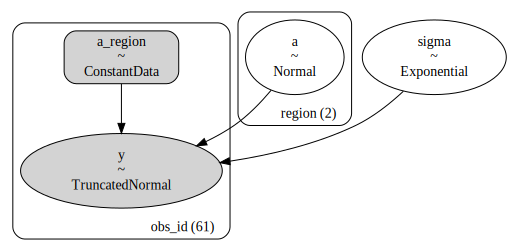

In [9]:
def assign_region(x, variable, label):
    if x in variable:
        d = label
    else:
        d = "other"
        
    return d
        



data = ndx[ndx.code == "G95"].copy()
data["region"] = data.city.map(lambda x: assign_region(x,  ['Saint-Sulpice (VD)'], "region"))
data["location"] = data.sensor.map(lambda x: assign_region(x, ["parc-des-pierrettes", "plage-de-st-sulpice"], "sensor"))
reg_idx, regs = pd.factorize(data.region)
sen_idx, sens = pd.factorize(data.location)
coords = {"region":["region", "other"], "location":["sensor", "other"], "obs_id": np.arange(len(data))}

with pm.Model(coords=coords) as ObjectModel:
    region_idx = pm.ConstantData("a_region", reg_idx, dims="obs_id")
    a = pm.Normal("a", mu=50, sigma=10, dims="region")
    
    theta = a[region_idx]
    sigma = pm.Exponential("sigma", 1.0)
    
    y = pm.TruncatedNormal("y", mu=theta,sigma=sigma, lower=0, observed=data.pcs_m.values, dims="obs_id")
    
pm.model_to_graphviz(ObjectModel)

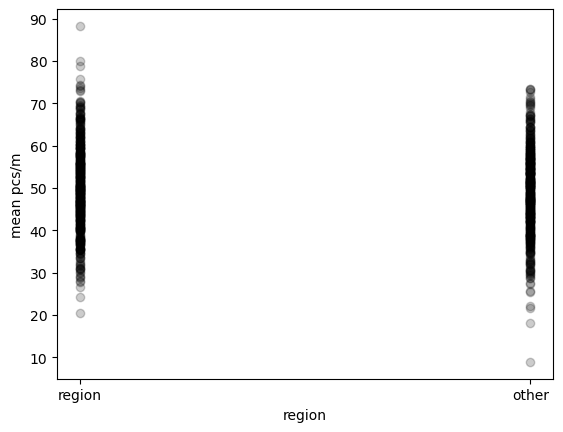

In [10]:
with ObjectModel:
    prior_checks = pm.sample_prior_predictive(random_seed=rng)
    

_, ax = plt.subplots()
prior_checks.prior.plot.scatter(x="region", y="a", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("mean pcs/m");    

In [11]:
with ObjectModel:
    sampled_r = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [12]:
az.summary(sampled_r)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[region],35.502,8.700,19.034,51.605,0.113,0.083,5959.0,3354.0,1.0
a[other],49.849,9.267,30.707,65.520,0.121,0.086,5782.0,2954.0,1.0
sigma,74.897,4.256,67.336,82.977,0.057,0.041,5647.0,3076.0,1.0


In [13]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    sampled_r.posterior_predictive.y.groupby(sampled_r.constant_data.a_region)
    .apply(hdi_helper)
    .y
)
np.round(hdi_ppc, 2)

<xarray.DataArray 'y' (a_region: 2, hdi: 2)>
array([[  0.  , 165.95],
       [  0.  , 177.28]])
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
  * a_region  (a_region) int64 0 1

In [36]:
sampled_r

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

<AxesSubplot:xlabel='y / y\nregion'>

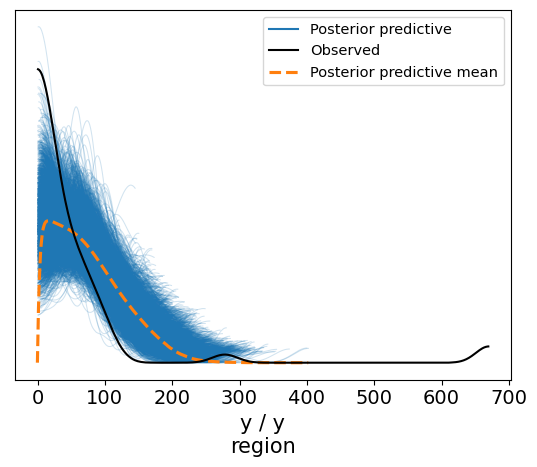

In [14]:
obs_county = sampled_r.posterior["region"][sampled_r.constant_data["a_region"]]

data = sampled_r.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(data, coords={'obs_id': ["region"]}, flatten=[])

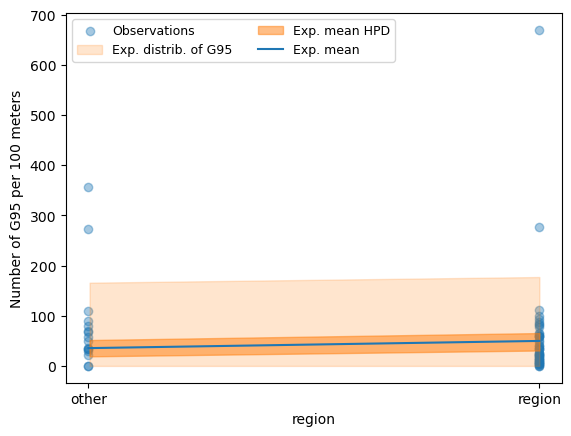

In [15]:
level_labels = sampled_r.posterior.region[sampled_r.constant_data.a_region]
sampled_r.observed_data = sampled_r.observed_data.assign_coords(region=level_labels).sortby(
    "region"
)

pooled_means = sampled_r.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
sampled_r.observed_data.plot.scatter(x="region", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1],
    hdi_data=hdi_ppc,
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of G95"},
    ax=ax,
)

az.plot_hdi(
    [0, 1], sampled_r.posterior.a, fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.a, label="Exp. mean")

ax.set_ylabel("Number of G95 per 100 meters")
ax.legend(ncol=2, fontsize=9, frameon=True);

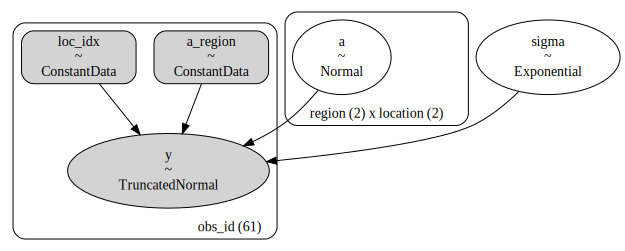

In [17]:
data = ndx[ndx.code == "G95"].copy()
data["region"] = data.city.map(lambda x: assign_region(x,  ['Saint-Sulpice (VD)'], "region"))
data["location"] = data.sensor.map(lambda x: assign_region(x, ["parc-des-pierrettes", "plage-de-st-sulpice"], "sensor"))
reg_idx, regs = pd.factorize(data.region)
sen_idx, sens = pd.factorize(data.location)
coords = {"region":["region", "other"], "location":["sensor", "other"], "obs_id": np.arange(len(data))}

with pm.Model(coords=coords) as ObjectSensorModel:
    loc_idx = pm.ConstantData("loc_idx", sen_idx, dims="obs_id")
    region_idx = pm.ConstantData("a_region", reg_idx, dims="obs_id")
    a = pm.Normal("a", mu=50, sigma=10, dims=("region", "location"))
    
    theta = a[region_idx, loc_idx]
    sigma = pm.Exponential("sigma", 1.0)
    
    y = pm.TruncatedNormal("y", mu=theta,sigma=sigma, lower=0, observed=data.pcs_m.values, dims="obs_id")
    
pm.model_to_graphviz(ObjectSensorModel)
                              
    

In [18]:
with ObjectSensorModel:
    sampled_rx = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_rx,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [19]:
az.summary(sampled_rx)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[region, sensor]",35.212,8.620,19.446,51.391,0.094,0.069,8372.0,3162.0,1.0
"a[region, other]",49.910,10.192,29.959,67.947,0.123,0.090,6844.0,3144.0,1.0
"a[other, sensor]",52.319,9.642,33.965,69.863,0.120,0.087,6475.0,3154.0,1.0
"a[other, other]",48.029,9.432,30.627,65.662,0.122,0.088,5953.0,3224.0,1.0
sigma,74.867,4.278,67.146,82.893,0.057,0.041,5702.0,3291.0,1.0


In [20]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    sampled_rx.posterior_predictive.y.groupby(sampled_rx.constant_data.loc_idx)
    .apply(hdi_helper)
    .y
)
np.round(hdi_ppc, 2)

<xarray.DataArray 'y' (loc_idx: 2, hdi: 2)>
array([[0.0000e+00, 1.6843e+02],
       [1.0000e-02, 1.7470e+02]])
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
  * loc_idx  (loc_idx) int64 0 1

<AxesSubplot:xlabel='y / y\nsensor'>

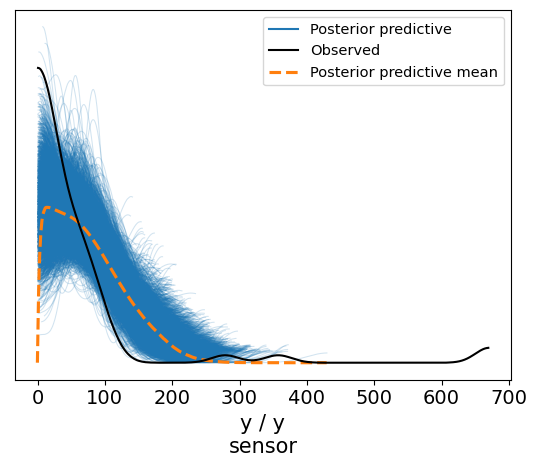

In [21]:
obs_county = sampled_rx.posterior["location"][sampled_rx.constant_data["loc_idx"]]

data = sampled_rx.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(data, coords={'obs_id': ["sensor"]}, flatten=[])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

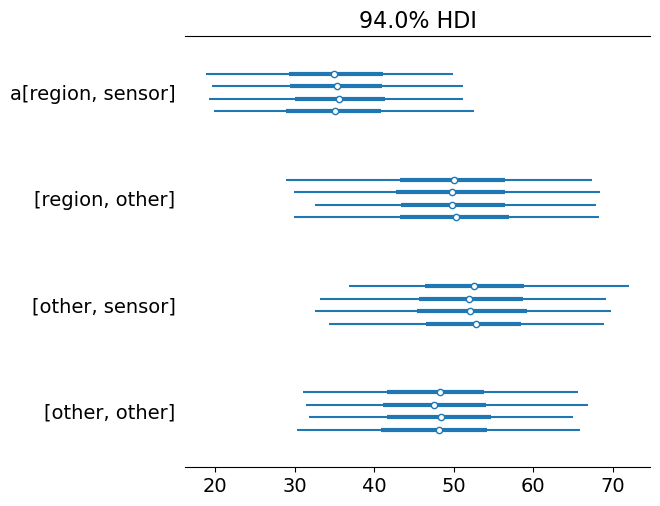

In [22]:
az.plot_forest(sampled_rx, var_names="a")

In [23]:
ndx.head()

,index,sensor,city,code,pcs_m
0,12639,boiron,Tolochenaz,G10,0.0
1,12640,boiron,Tolochenaz,G100,2.0
2,12652,boiron,Tolochenaz,G112,0.0
3,12657,boiron,Tolochenaz,G117,0.0
4,12714,boiron,Tolochenaz,G177,7.0


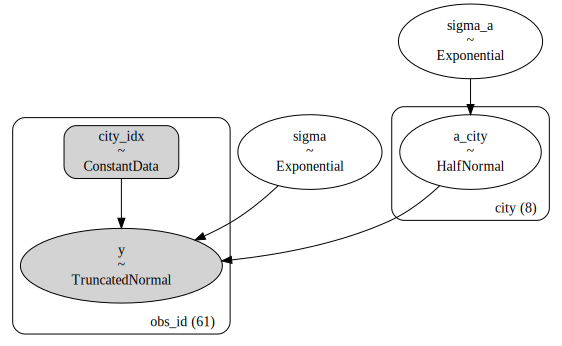

In [24]:
data = ndx[ndx.code == "G95"].copy()
data["region"] = data.city.map(lambda x: assign_region(x,  ['Saint-Sulpice (VD)'], "region"))
data["location"] = data.sensor.map(lambda x: assign_region(x, ["parc-des-pierrettes", "plage-de-st-sulpice"], "sensor"))
reg_idx, regs = pd.factorize(data.region)
sen_idx, sens = pd.factorize(data.location)
cit_idx, cits = pd.factorize(data.city)
coords = {"region":["region", "other"], "location":["sensor", "other"], "obs_id": np.arange(len(data))}
coords["city"] = cits
with pm.Model(coords=coords) as PartialObjectSensor:
    
    city_idx = pm.ConstantData("city_idx", cit_idx, dims="obs_id")
    sigma_a = pm.Exponential("sigma_a", 1.0)
    
    # Varying intercepts:
    a_city = pm.HalfNormal("a_city", sigma=sigma_a, dims="city")
    
    # Expected value per city:
    theta = a_city[city_idx]
    
    # theta = a[region_idx, loc_idx]
    sigma = pm.Exponential("sigma", 1.0)
    
    y = pm.TruncatedNormal("y", mu=theta,sigma=sigma, lower=0, observed=data.pcs_m.values, dims="obs_id")
pm.model_to_graphviz(PartialObjectSensor)   

In [25]:
with PartialObjectSensor:
    sampled_rpo = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_rpo,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, a_city, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7159, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9322, but should be close to 0.8. Try to increase the number of tuning steps.


In [26]:
az.summary(sampled_rpo)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.981,0.986,0.000,2.865,0.037,0.026,459.0,468.0,1.01
a_city[Tolochenaz],0.759,1.101,0.000,2.716,0.031,0.022,633.0,768.0,1.01
a_city[Bourg-en-Lavaux],0.783,1.088,0.000,2.733,0.033,0.024,566.0,620.0,1.01
a_city[Morges],0.791,1.137,0.000,2.846,0.035,0.025,552.0,582.0,1.01
a_city[Allaman],0.776,1.135,0.000,2.737,0.033,0.023,584.0,685.0,1.01
a_city[Lausanne],0.817,1.227,0.000,2.962,0.035,0.025,608.0,741.0,1.01
a_city[Saint-Sulpice (VD)],0.823,1.203,0.000,2.944,0.036,0.025,574.0,717.0,1.01
a_city[Préverenges],0.725,1.041,0.000,2.513,0.032,0.023,535.0,552.0,1.01
a_city[Rolle],0.782,1.109,0.000,2.670,0.033,0.023,555.0,670.0,1.01
sigma,79.182,4.145,72.214,87.653,0.095,0.067,1961.0,1970.0,1.00


<AxesSubplot:xlabel='y / y'>

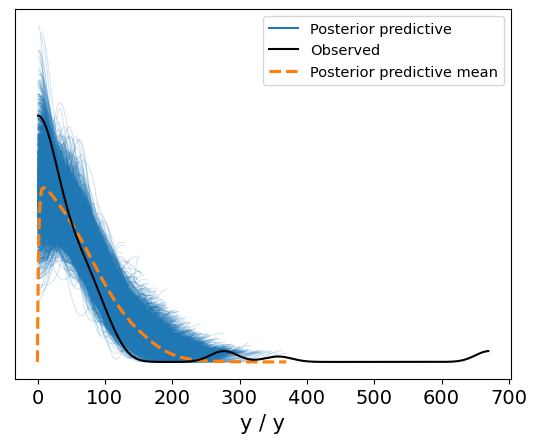

In [27]:
az.plot_ppc(sampled_rpo)

<AxesSubplot:xlabel='y / y\nSaint-Sulpice (VD)'>

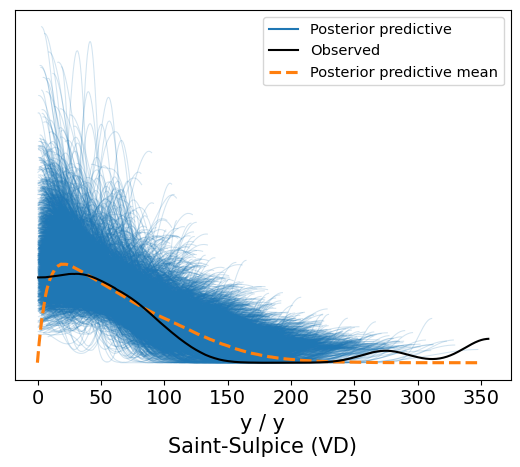

In [40]:
obs_county = sampled_rpo.posterior["city"][sampled_rpo.constant_data["city_idx"]]

dt = sampled_rpo.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(dt, coords={'obs_id': ["Saint-Sulpice (VD)"]}, flatten=[])

<AxesSubplot:xlabel='y / y\nLausanne'>

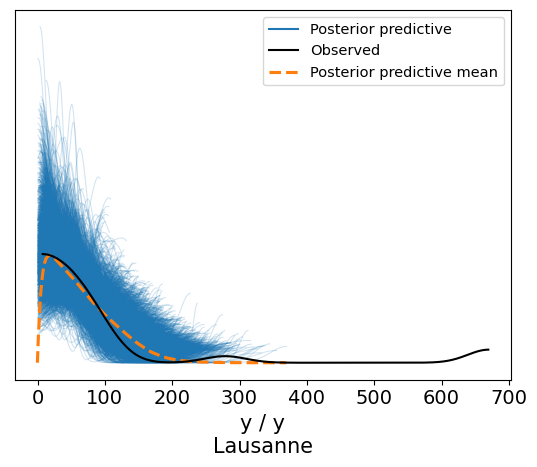

In [42]:
az.plot_ppc(dt, coords={'obs_id': ["Lausanne"]}, flatten=[])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

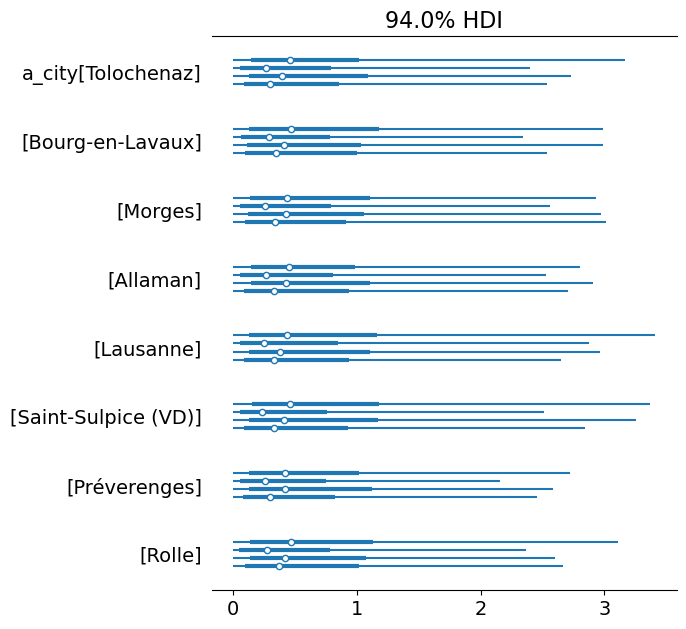

In [28]:
az.plot_forest(sampled_rpo, var_names="a_city")

In [29]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    sampled_rx.posterior_predictive.y.groupby(sampled_rpo.constant_data.city_idx)
    .apply(hdi_helper)
    .y
)
np.round(hdi_ppc, 2)

<xarray.DataArray 'y' (city_idx: 8, hdi: 2)>
array([[2.0000e-02, 1.6566e+02],
       [2.0000e-02, 1.6825e+02],
       [1.2000e-01, 1.6512e+02],
       [4.0000e-02, 1.6656e+02],
       [0.0000e+00, 1.6699e+02],
       [2.0000e-02, 1.7634e+02],
       [1.0000e-02, 1.6665e+02],
       [7.0000e-02, 1.6546e+02]])
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
  * city_idx  (city_idx) int64 0 1 2 3 4 5 6 7

In [43]:
data = ndx[ndx.code == "G95"].copy()
data["region"] = data.city.map(lambda x: assign_region(x,  'Saint-Sulpice (VD)', "region"))
data["location"] = data.sensor.map(lambda x: assign_region(x, ["parc-des-pierrettes", "plage-de-st-sulpice"], "sensor"))
reg_idx, regs = pd.factorize(data.region)
sen_idx, sens = pd.factorize(data.location)
cit_idx, cits = pd.factorize(data.city)
coords = {"region":["region", "other"], "location":["sensor", "other"], "obs_id": np.arange(len(data))}
coords["city"] = cits
coords["locations"] = sens

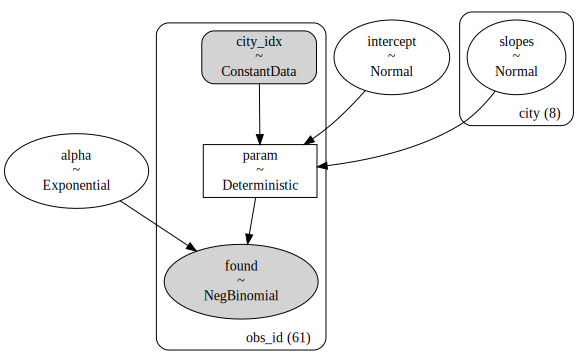

In [55]:
with pm.Model(coords=coords) as varying_intercept_slope:
    
    a = pm.Normal("intercept", mu=0, sigma=1)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="city")
    # c = pm.Normal("c", mu=0, sigma=1, dims="locations")
   
    
    # sensor_idx = pm.ConstantData("sensor_idx", sen_idx, dims="obs_id")
    city_idx = pm.ConstantData("city_idx", cit_idx, dims="obs_id")
    
    λ =pm.Deterministic("param", pm.math.exp(a + b[city_idx]), dims="obs_id")
    
    alpha = pm.Exponential("alpha", 1)
    y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=data.pcs_m.values, dims="obs_id")
    


pm.model_to_graphviz(varying_intercept_slope)



In [56]:
with varying_intercept_slope:
    sampled_rpi = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_rpi,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [59]:
az.summary(sampled_rpi, var_names=["slopes", "intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[Tolochenaz],-0.218,0.648,-1.430,0.997,0.012,0.009,2939.0,3009.0,1.0
slopes[Bourg-en-Lavaux],0.559,0.617,-0.558,1.733,0.012,0.009,2780.0,2790.0,1.0
slopes[Morges],-0.764,0.972,-2.561,1.082,0.016,0.013,3560.0,3092.0,1.0
slopes[Allaman],0.897,0.568,-0.208,1.923,0.012,0.008,2266.0,2757.0,1.0
slopes[Lausanne],1.372,0.435,0.589,2.219,0.011,0.008,1483.0,2173.0,1.0
slopes[Saint-Sulpice (VD)],1.228,0.444,0.434,2.091,0.011,0.008,1511.0,1875.0,1.0
slopes[Préverenges],-0.033,0.461,-0.915,0.817,0.011,0.008,1613.0,2332.0,1.0
slopes[Rolle],-0.102,0.789,-1.509,1.442,0.013,0.012,3575.0,2680.0,1.0
intercept,3.111,0.393,2.388,3.856,0.011,0.008,1260.0,1650.0,1.0


<AxesSubplot:xlabel='found / found\nSaint-Sulpice (VD)'>

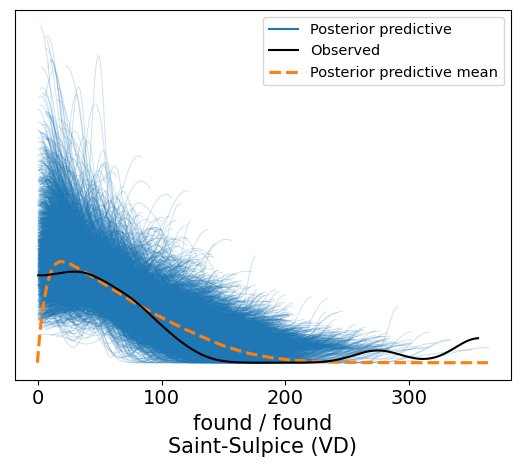

In [82]:
obs_county = sampled_rpi.posterior["city"][sampled_rpi.constant_data["city_idx"]]

dt = sampled_rpi.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(dt, coords={'obs_id': ['Saint-Sulpice (VD)']}, flatten=[])

In [83]:
dt.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, obs_id: 61)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs_id   (obs_id) <U18 'Tolochenaz' 'Tolochenaz' ... 'Saint-Sulpice (VD)'
    city     (obs_id) <U18 'Tolochenaz' 'Tolochenaz' ... 'Saint-Sulpice (VD)'
Data variables:
    found    (chain, draw, obs_id) float64 7.045 108.0 124.6 ... 1.974 65.29
Attributes:
    created_at:                 2022-11-08T07:29:53.762222
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.7

In [94]:
dt.posterior_predictive.found["obs_id"]

<xarray.DataArray 'obs_id' (obs_id: 61)>
array(['Tolochenaz', 'Tolochenaz', 'Bourg-en-Lavaux', 'Bourg-en-Lavaux',
       'Morges', 'Allaman', 'Allaman', 'Allaman', 'Lausanne', 'Lausanne',
       'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne',
       'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne', 'Saint-Sulpice (VD)',
       'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)',
       'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)',
       'Saint-Sulpice (VD)', 'Préverenges', 'Préverenges', 'Préverenges',
       'Préverenges', 'Préverenges', 'Préverenges', 'Préverenges',
       'Préverenges', 'Préverenges', 'Préverenges', 'Préverenges',
       'Préverenges', 'Préverenges', 'Préverenges', 'Préverenges', 'Rolle',
       'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)',
       'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)', 'Tolochenaz', 'Lausanne',
       'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne', 'Lausanne',
       'Lausanne', 'Saint-Sulpice (VD)', 'Saint-Sulpice (VD)',
       'Saint-Sulpice (VD)'], dtype='<U18')
Coordinates:
  * obs_id   (obs_id) <U18 'Tolochenaz' 'Tolochenaz' ... 'Saint-Sulpice (VD)'
    city     (obs_id) <U18 'Tolochenaz' 'Tolochenaz' ... 'Saint-Sulpice (VD)'

<AxesSubplot:xlabel='found / found\nLausanne'>

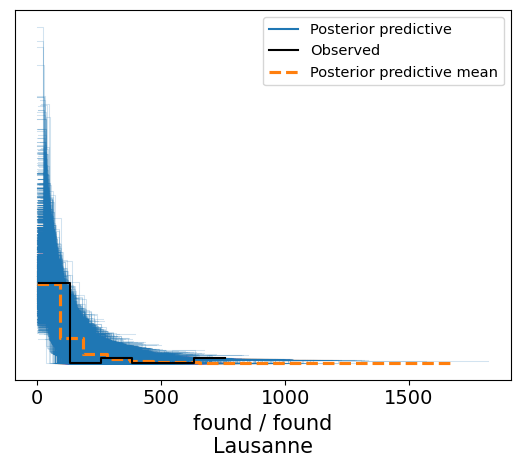

In [64]:
obs_county = sampled_rpi.posterior["city"][sampled_rpi.constant_data["city_idx"]]

dt = sampled_rpi.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(dt, coords={'obs_id': ['Lausanne']}, flatten=[])

In [65]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]], hdi_prob=.94)
hdi_ppc = (
    sampled_rpi.posterior_predictive.found.groupby(sampled_rpi.constant_data.city_idx)
    .apply(hdi_helper)
    .found
)
np.round(hdi_ppc, 2)

<xarray.DataArray 'found' (city_idx: 8, hdi: 2)>
array([[  0.,  72.],
       [  0., 155.],
       [  0.,  65.],
       [  0., 196.],
       [  0., 276.],
       [  0., 243.],
       [  0.,  70.],
       [  0., 102.]])
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
  * city_idx  (city_idx) int64 0 1 2 3 4 5 6 7

In [66]:
#hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]], hdi_prob=.94)
hdi_ppc = (
    sampled_rpi.posterior_predictive.found.groupby(sampled_rpi.constant_data.city_idx).mean())
hdi_ppc[0][1]

<xarray.DataArray 'found' (city_idx: 8)>
array([316.66666667,  73.        ,  22.        ,  42.66666667,
       131.3       ,  54.6875    ,  34.2       ,   3.        ])
Coordinates:
    chain     int64 0
    draw      int64 1
  * city_idx  (city_idx) int64 0 1 2 3 4 5 6 7

<AxesSubplot:xlabel='found / found'>

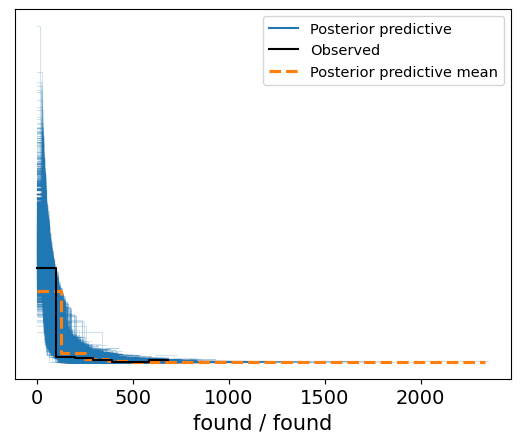

In [67]:
az.plot_ppc(sampled_rpi)

In [68]:
with pm.Model(coords=coords) as varying_intercept_slope:
    
    a = pm.Normal("intercept", mu=0, sigma=1)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="city")
    # c = pm.Normal("c", mu=0, sigma=1, dims="locations")
   
    
    # sensor_idx = pm.ConstantData("sensor_idx", sen_idx, dims="obs_id")
    city_idx = pm.ConstantData("city_idx", cit_idx, dims="obs_id")
    
    λ =pm.Deterministic("param", a + b[city_idx], dims="obs_id")
    
    alpha = pm.Exponential("alpha", 1)
    y = pm.TruncatedNormal("found", mu=λ, sigma=alpha, lower=0, observed=data.pcs_m.values, dims="obs_id")

In [69]:
with varying_intercept_slope:
    sampled_rpi = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_rpi,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


<AxesSubplot:xlabel='found / found\nLausanne'>

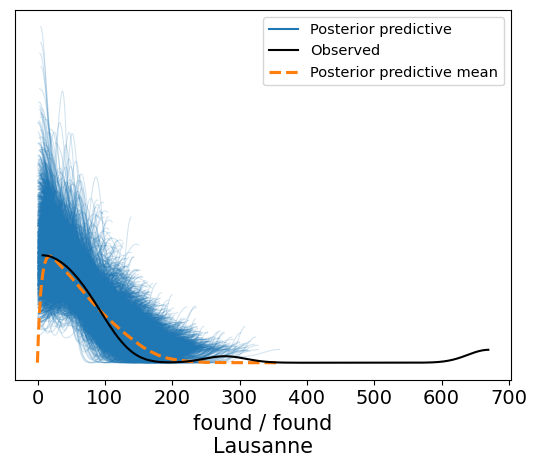

In [70]:
obs_county = sampled_rpi.posterior["city"][sampled_rpi.constant_data["city_idx"]]

dt = sampled_rpi.assign_coords(obs_id=obs_county, groups="observed_vars")

az.plot_ppc(dt, coords={'obs_id': ["Lausanne"]}, flatten=[])

In [72]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]], hdi_prob=.94)
hdi_ppc = (
    sampled_rpi.posterior_predictive.found.groupby(sampled_rpi.constant_data.city_idx)
    .apply(hdi_helper)
    .found
)
np.round(hdi_ppc, 2)

<xarray.DataArray 'found' (city_idx: 8, hdi: 2)>
array([[2.0000e-02, 1.4659e+02],
       [3.0000e-02, 1.5085e+02],
       [1.0000e-02, 1.4880e+02],
       [0.0000e+00, 1.4965e+02],
       [0.0000e+00, 1.4969e+02],
       [0.0000e+00, 1.5048e+02],
       [0.0000e+00, 1.4898e+02],
       [1.0000e-02, 1.5116e+02]])
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
  * city_idx  (city_idx) int64 0 1 2 3 4 5 6 7

In [ ]:
def summary_percode(code, results):
    d = results[code][0]
    e = az.summary(d, var_names=["intercept", "slopes"], kind='stats')
    v = np.exp(e)
    vi = v.product(axis=0)
    vi["code"] = code
    vi["predicted-mean"] = results[code][0].posterior_predictive.found.mean().to_numpy().item()
    return vi

def collect_summaries(codes, results, location):
    
    vis = []
    for code in codes:
        f = summary_percode(code, results)
        f["location"] = location
        vis.append(f)
    return vis


def select_for_a_code(code, data):    
    d = data[data.code == code][["pcs_m", "sensor", *variables]].copy()
    d.reset_index(inplace=True, drop = True)
    return d



def add_location_column(location, data):
    data[location] = False
    data.loc[data['sensor'] == location, location] = True
    return data

def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city","region:lake"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1)
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        F = pm.ConstantData("lake",  data["lake"].to_numpy(), dims="obs_idx")
        
        λ =pm.Deterministic("param", pm.math.exp(a + b[0]*C + b[1]*D + b[2]*F*E), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=data.pcs_m.to_numpy(), dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d



In [ ]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']


# make maps to found and guessed values
def select_and_aggregate_records(data, location, column):
    d = data[data.sensor == location].groupby("code").pcs_m.mean()
    return d

def make_amap_to_found_code_values(data, location):
    d = data[eixd.sensor == location][["code", "pcs_m"]].set_index("code", drop=True)
    return d["pcs_m"]

def add_guessed_found_column(d, amap, col_name):
    d[col_name] = d.code.map(lambda x: amap.loc[x])
    return d

def the_difference_between_guessed_predicted(d):
    d["guessed-diff"] = d["guessed"] - d["found"]
    d["predicted-diff"] = d["predicted-mean"] - d["found"]
    return d

def the_diiference_squared(d, location, guess_map, found_map):
    
    data = d[d.sensor == location].copy()
    data = add_guessed_found_column(data,  guess_map, "guessed")
    data = add_guessed_found_column(data, found_map, "found")
    data = the_difference_between_guessed_predicted(data)
    data["abs_guessed"] = data["guessed-diff"].abs()
    data["abs_predicted"] =data["predicted-diff"].abs()
    data["guessed <= predicted"] = data["abs_guessed"] <= data["abs_predicted"]
       
    return data
    


In [ ]:
def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city", "region"], "intercepts":["r"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1, dims="intercepts")
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        O = pm.ConstantData("observed", data["pcs_m"].to_numpy(), dims="obs_idx")
        
        
        λ =pm.Deterministic("param", pm.math.exp(a*E + b[0]*C + b[1]*D), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=O, dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d

